<a href="https://colab.research.google.com/github/santule/oomdena_earthquake/blob/main/3_2_hierarchical_pathfinding_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical A* path finding algorithm

Created by - Sanjana Tule

Date - 19/08/2021


* **Implement weighted risk factor**. 

Give higher weightage to risk factors compared to length. As length = 10 and risk = 2 vs length = 2 and risk = 10 should not be the same.
Weighted Risk Factor = Length + 2 * ( Building Density Risk + Distance Risk)

* **Algorithm steps/description**:

Inspired and based on ideas in the paper - https://www.researchgate.net/publication/228785110_Near_optimal_hierarchical_path-finding_HPA

Hierarchical A* algorithm are sub-optimal compared to A* but they are faster. In life threatning situations they would be most suitable than traditional A* as A* finds the complete path before returning the navigation to the user. Compared to that Hierarchical A* only returns abstract navigation path and can calculate the subpaths in parallel while the user is navigating.

Assumptions:
1.   All Street are 2 way as for earthquake people would be walking or even one-way signs can be ignored for safety purposes
2.   For implemenation simplicity only 1 entrance/exit pair between clusters are considered. But in reality we may need to store all of them as the in-flight risk might change as people navigate.

**PART 1 - Pre-processing steps to create abstract graph**
Implemented seperately and graph stored on disk

**PART 2 - Run-time steps ( search for path)**:

1.   Select the source s and destination d.
2.   Find the closest node from abstract graph a_s to s.
3.   Find the closest node from abstract graph d_s to d.
4.   Find the path betwen s and a_s in the original underlying detailed graph.
5.   Find the path betwen d and a_d in the original underlying detailed graph.
6.   Find the path between a_s and a_d in abstract graph.
7.   Plot all the paths together.


**PART 2 - FIND PATH USING ABSTRACT GRAPH**

In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [2]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import math
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PART 2 - PATH FINDING USING ABSTRACT AND DETAILED GRAPH

In [3]:
# Load abstract and detailed graph
graph_detailed = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
graph_abstract = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/3_abstract_graph_25.pickle')

nodes_nr_all,edges = ox.graph_to_gdfs(graph_detailed)
abstract_intra_nodes = ox.graph_to_gdfs(graph_abstract,edges=False)

edges['combined_risk_per_length'] = edges['combined_risk'] * edges['length']
display(edges.head())

# Make the graph again
graph_detailed = ox.graph_from_gdfs(nodes_nr_all,edges)

osmid  ... combined_risk_per_length
u          v          key                          ...                         
21569692   4682380491 0    [185913115, 401489878]  ...               636.251146
           6784129512 0                 401489883  ...                12.955000
           6784129514 0                 401489877  ...                20.032500
4682380491 21569692   0    [185913115, 401489878]  ...               636.251146
           4682381110 0                 474236841  ...               101.304831

[5 rows x 21 columns]

In [6]:
 ##################################### PART 2 - FIND THE ROUTE #################################################################
 ###############################################################################################################################

def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values.

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates



# custom plot route function
def plot_route(complete_path,graph_abstract,graph_detailed):
  '''
  This function is used to plot the graph. has to be custom written as abstract edges do not exist in the underlying graph

  Parameters
  ----------
  complete_path: list
  graph_abstract: MultiDiGraph
  graph_detailed: MultiDiGraph
  
  Returns
  -------
  NA

  '''
  abstract_intra_nodes_,abstract_edges_ = ox.graph_to_gdfs(graph_abstract)
  detailed_nodes_,edges_nr_all = ox.graph_to_gdfs(graph_detailed)

  complete_path_df = pd.DataFrame()
  for ind,se in enumerate(complete_path):
    if ind != len(complete_path)-1:
      try:
        complete_path_df = complete_path_df.append(abstract_edges_.loc[(se,complete_path[ind+1],0)])
      except:
        complete_path_df = complete_path_df.append(edges_nr_all.loc[(se,complete_path[ind+1],0)])

  complete_path_df_ = geopandas.GeoDataFrame(complete_path_df,geometry='geometry')

  # plot Hieararchical A* path
  fig, ax = plt.subplots(figsize=(20,20))
  ax.set_title('Visualise the Path using Hierarchical A* Algorithm')
  #edges_nr_all.plot(ax=ax, linewidth=1, column='combined_risk', cmap='seismic')
  edges_nr_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')
  complete_path_df_.plot(ax=ax, linewidth=3, edgecolor='green')


# find the distance to the nearest node
def find_close_node_in_abstract_graph(graph_abstract_nodes,source_node,graph_detailed_nodes):

  '''
  This function finds the closest node in the abstract graph

  Parameters
  ----------
  graph_abstract_nodes: dataframe
  source_node: integer
  graph_detailed_nodes: dataframe
  
  Returns
  -------
  NA

  '''

  detailed_source_point = (graph_detailed_nodes.loc[(source_node)].x , graph_detailed_nodes.loc[(source_node)].y)
  euc_distance_nearest_node_abstract_graph = graph_abstract_nodes.geometry.apply(lambda x: get_euclidean_distance(detailed_source_point,x))

  return euc_distance_nearest_node_abstract_graph.sort_values().index.values[0]

# euclidean distance
def get_euclidean_distance(s,geom):
    return ox.distance.euclidean_dist_vec(s[1],s[0],geom.bounds[1],geom.bounds[0])

# euclidean distance reverse
def get_euclidean_distance_r(s,geom):
    return ox.distance.euclidean_dist_vec(s[0],s[1],geom.bounds[1],geom.bounds[0])

# nearest park
def find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,type):
  nodes_park = graph_detailed_nodes[graph_detailed_nodes['evacuation_type']== type]
  euc_distance_parks = nodes_park.geometry.apply(lambda x: get_euclidean_distance_r(source_coordinates,x))
  return euc_distance_parks.sort_values().index.values[0]
  
# find shortest route
def find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,graph_abstract_nodes,graph_detailed_nodes):

  # find nearest node to the address in the detailed graph
  source_node, source_dist = ox.get_nearest_node(graph_detailed,source_coordinates,return_dist=True)
  #print('source node in detailed graph',source_node)

  # find the nearest node in the abstract graph
  source_abs_graph_node = find_close_node_in_abstract_graph(graph_abstract_nodes,source_node,graph_detailed_nodes)
  #print('source node in abstract graph',source_abs_graph_node)

  # record time
  start_time = time.time()

  # find the shortest path between source node in detailed graph to source node in the abstract graph
  shortest_path_source_to_source_abs = nx.astar_path(G=graph_detailed,source=source_node, target=source_abs_graph_node, heuristic = None, weight='combined_risk_per_length')
  #print("FIRST HALF - Source Address to Source Node in Abstract Graph",shortest_path_source_to_source_abs)

  # find the destination if not given
  if choice_of_destination == 1: # park
    dest_node = find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,'park')
  elif choice_of_destination == 2: # shelter
    dest_node = find_nearest_park_shelter(graph_detailed_nodes,source_coordinates,'shelter')
  else:
    # find nearest node to the address in the detailed graph
    dest_node, dest_dist = ox.get_nearest_node(graph_detailed,destination_coordinates,return_dist=True)

  # find the nearest node in the abstract graph
  dest_abs_graph_node = find_close_node_in_abstract_graph(graph_abstract_nodes,dest_node,graph_detailed_nodes)
  #print('destination node in abstract graph',dest_abs_graph_node) 

  # find the middle path in the abstract path
  shortest_path_abs = nx.astar_path(G = graph_abstract, source=source_abs_graph_node, target=dest_abs_graph_node, heuristic = None, weight='combined_risk_per_length')
  #print("MIDDLE ROUTE - Source to Destination Node in Abstract Graph",shortest_path_abs)

  # find the shortest path betwen destination node in detailed graph to the destination node in the abstract graph
  shortest_path_dest_to_dest_abs = nx.astar_path(G =graph_detailed,source=dest_abs_graph_node, target=dest_node, heuristic = None, weight='combined_risk_per_length')
  #print("SECOND HALF - Destination Address to Destination Node in Abstract Graph",shortest_path_dest_to_dest_abs)

  if len(shortest_path_abs) == 1: # if source and destination are in same cluster
    shortest_path_source_to_source_abs = shortest_path_source_to_source_abs[1:-1]

  # Join the Shortest Route together
  complete_path  = shortest_path_source_to_source_abs  + shortest_path_abs[1:-1] + shortest_path_dest_to_dest_abs
  #print('COMPLETE ROUTE -',complete_path)

  A_time = (time.time() - start_time)
  print("TOTAL TIME",A_time)

  # Plot route
  plot_route(complete_path,graph_abstract,graph_detailed)

  # length and risk
  total_length = sum(nx.Graph(graph_detailed)[u][v].get('length') for u, v in zip(shortest_path_source_to_source_abs[:-1], shortest_path_source_to_source_abs[1:]))
  total_risk = sum(nx.Graph(graph_detailed)[u][v].get('combined_risk_per_length') for u, v in zip(shortest_path_source_to_source_abs[:-1], shortest_path_source_to_source_abs[1:]))
  total_length = total_length + sum(nx.Graph(graph_abstract)[u][v].get('length') for u, v in zip(shortest_path_abs[:-1], shortest_path_abs[1:]))
  total_risk = total_risk + sum(nx.Graph(graph_abstract)[u][v].get('combined_risk_per_length') for u, v in zip(shortest_path_abs[:-1], shortest_path_abs[1:]))
  total_length = total_length + sum(nx.Graph(graph_detailed)[u][v].get('length') for u, v in zip(shortest_path_dest_to_dest_abs[:-1], shortest_path_dest_to_dest_abs[1:]))
  total_risk = total_risk + sum(nx.Graph(graph_detailed)[u][v].get('combined_risk_per_length') for u, v in zip(shortest_path_dest_to_dest_abs[:-1], shortest_path_dest_to_dest_abs[1:]))

  # total length and risk
  print("LENGTH OF THE ROUTE",total_length)
  print("RISK OF THE ROUTE",total_risk)

DEMO 1 - 
FIND PATH FOR CUSTOM DESTINATION

TOTAL TIME 0.07827234268188477
LENGTH OF THE ROUTE 12979.974000000002
RISK OF THE ROUTE 20601.996577383907


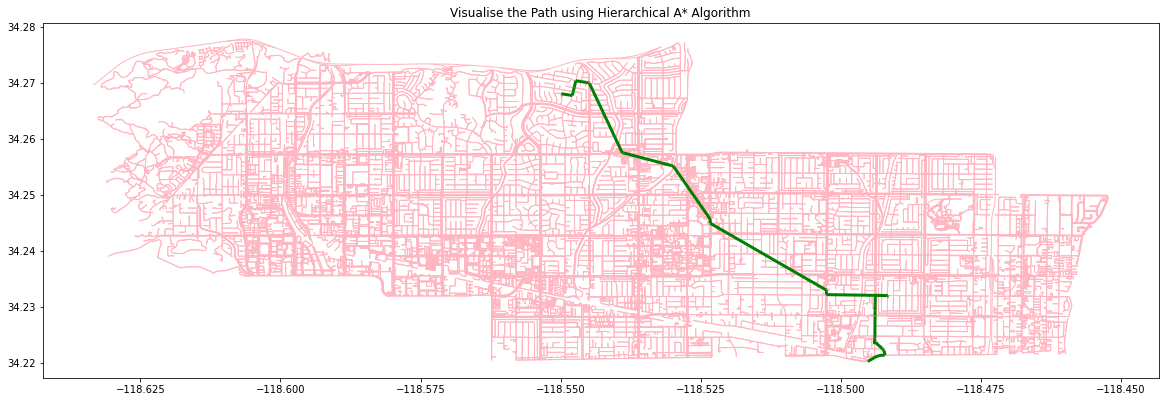

In [7]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address.')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "7741 Hayvenhurst Ave, Van Nuys, CA 91406"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all)

# Demo purposes - option 3
# Source Address = 19130 Tulsa St, Northridge, CA 91326
# Destination Address = '7741 Hayvenhurst Ave, Van Nuys, CA 91406'

TOTAL TIME 0.10413169860839844
LENGTH OF THE ROUTE 23035.397999999994
RISK OF THE ROUTE 35733.33258335697


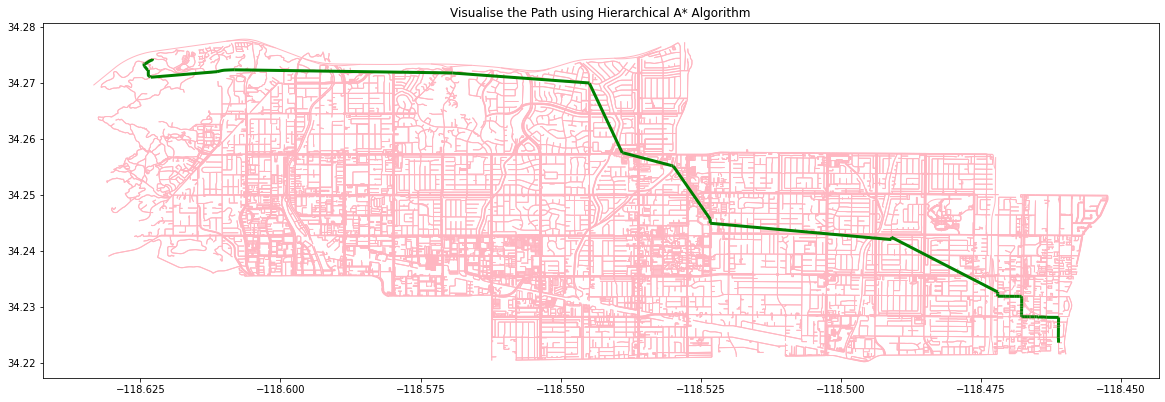

In [8]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "22801 Santa Susana Pass Rd, Chatsworth, CA 91311"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "8418 Noble Ave, North Hills, CA 91326"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)

# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 8418 Noble Ave, North Hills, CA 91326

TOTAL TIME 0.26170802116394043
LENGTH OF THE ROUTE 21524.645999999993
RISK OF THE ROUTE 31122.676508011344


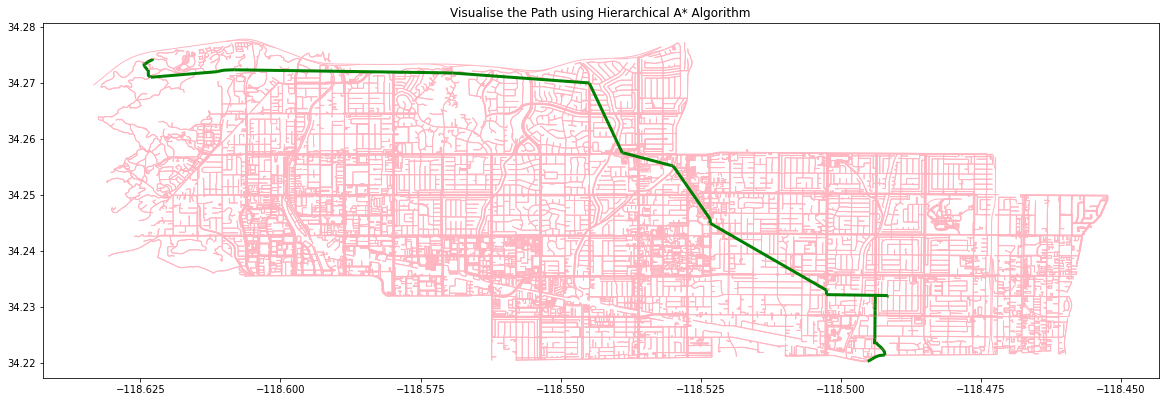

In [9]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 3
source_address = "22801 Santa Susana Pass Rd, Chatsworth, CA 91311"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_address = "7741 Hayvenhurst Ave, Van Nuys, CA 91406"
destination_coordinates = convertAddressToGeoCoordinates(destination_address)

# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

DEMO 2 - 
FIND PATH FOR NEAREST PARK


TOTAL TIME 0.026717662811279297
LENGTH OF THE ROUTE 1684.3980000000001
RISK OF THE ROUTE 3775.2255948245306


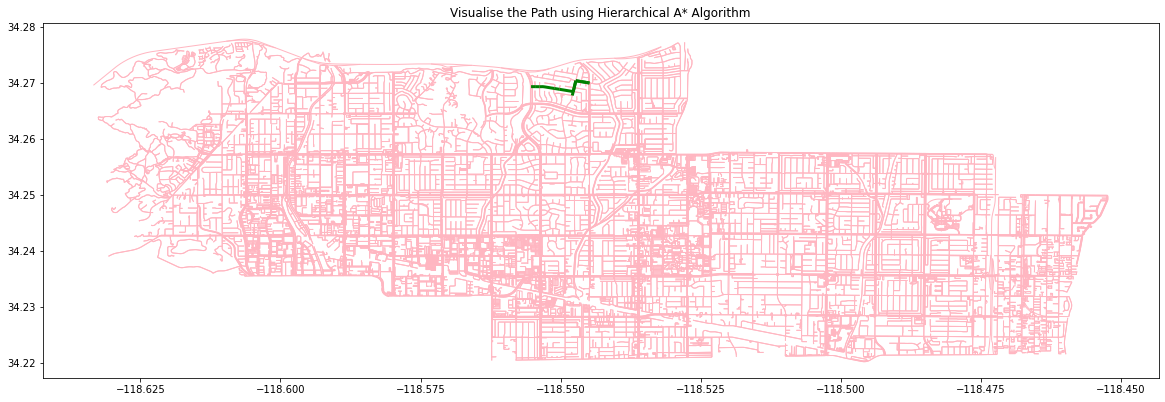

In [10]:
###### MAIN FUNCTION - NEAREST PARK #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#   destination_address = 'NA'

choice_of_destination = 1
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_coordinates = ''
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all)

# 19130 Tulsa St, Northridge, CA 91326

DEMO 3 - 
FIND PATH FOR NEAREST SHELTER

TOTAL TIME 0.021811246871948242
LENGTH OF THE ROUTE 4040.5259999999994
RISK OF THE ROUTE 6649.337162974123


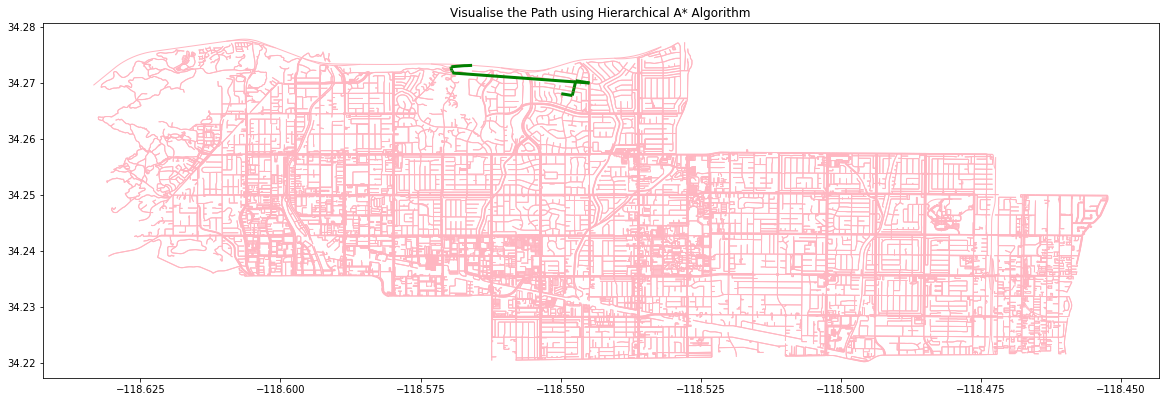

In [11]:
###### MAIN FUNCTION - NEAREST SHELTER #####

# source_address = input('Enter your Current Address ')
# choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

# if choice_of_destination not in (1,2,3):
#   print("Wrong Choice")

# if choice_of_destination == 3:
#   destination_address = input('Please give the Custom Destination Address.')
# else:
#  destination_address = 'NA'

choice_of_destination = 2
source_address = "19130 Tulsa St, Northridge, CA 91326"
source_coordinates = convertAddressToGeoCoordinates(source_address)
destination_coordinates = ''
  
# find shortest route and plot it
find_route(source_coordinates,destination_coordinates,choice_of_destination,graph_detailed,graph_abstract,abstract_intra_nodes,nodes_nr_all)